In [16]:
# ========= BUSCADOR EN EQUIPO / JUGADORES =========
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

# Ajustá estas dos rutas base:
BASE = Path("/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union")
DIR_EQUIPO    = BASE / "Equipo"
DIR_JUGADORES = BASE / "Jugadores"

def _find_equipo_file():
    patterns = [
        "UnionEzpeletaEq*.xml", "UnionEzpeletaEq*.asxml",
        "*Union*EzpeletaEq*.xml", "*Union*EzpeletaEq*.asxml",
    ]
    candidates = []
    for d in [DIR_EQUIPO, DIR_JUGADORES]:
        if not d.exists(): continue
        for pat in patterns:
            candidates += list(d.glob(pat))
            candidates += list(d.rglob(pat))  # incluye subcarpetas

    candidates = sorted(set(candidates), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        print("⚠️ No encontré 'UnionEzpeleta*.xml/asxml' en Equipo/Jugadores.")
        print("📁 Equipo contiene:")
        if DIR_EQUIPO.exists():
            for p in DIR_EQUIPO.iterdir(): print("  -", p.name)
        print("📁 Jugadores contiene:")
        if DIR_JUGADORES.exists():
            for p in DIR_JUGADORES.iterdir(): print("  -", p.name)
        return None
    return candidates[0]

# ========= PARSEO Y CÁLCULO DE MINUTOS =========
_NAME_ROLE_RE = re.compile(r"^\s*([^(]+?)\s*\(([^)]+)\)\s*$")
def _split_name_role(code: str):
    m = _NAME_ROLE_RE.match(str(code)) if code else None
    return (m.group(1).strip(), m.group(2).strip()) if m else (None, None)

def _merge_intervals(intervals):
    ints = [(float(s), float(e)) for s, e in intervals if s is not None and e is not None and e > s]
    if not ints: return []
    ints.sort()
    merged = [list(ints[0])]
    for s, e in ints[1:]:
        if s <= merged[-1][1]:
            merged[-1][1] = max(merged[-1][1], e)
        else:
            merged.append([s, e])
    return [(s, e) for s, e in merged]

def cargar_equipo_presencias(xml_path: Path) -> pd.DataFrame:
    """
    Lee el XML del equipo (en carpeta Equipo) y devuelve:
    code, nombre, rol, start_s, end_s, dur_s
    Contamos solo entradas con 'Nombre (Rol)' y tiempos válidos.
    """
    root = ET.parse(xml_path).getroot()
    rows = []
    for inst in root.findall(".//instance"):
        code = inst.findtext("code")
        nombre, rol = _split_name_role(code)
        if nombre is None:  # ignorar instancias que no sean "Nombre (Rol)"
            continue
        st = inst.findtext("start"); en = inst.findtext("end")
        try:
            s = float(st) if st is not None else None
            e = float(en) if en is not None else None
        except Exception:
            s, e = None, None
        if s is None or e is None or e <= s:
            continue
        rows.append({"code": code, "nombre": nombre, "rol": rol,
                     "start_s": s, "end_s": e, "dur_s": e - s})
    return pd.DataFrame(rows)

# === Helpers de formato ===
def _format_mmss(seconds: float | int) -> str:
    """Convierte segundos -> 'MM:SS' con cero a la izquierda."""
    if seconds is None or not np.isfinite(seconds):
        return "00:00"
    s = int(round(float(seconds)))
    mm, ss = divmod(s, 60)
    return f"{mm:02d}:{ss:02d}"

def _inside_bar_label(ax, bars, values_sec):
    """
    Pone el texto MM:SS dentro de cada barra. Si la barra es muy corta, lo empuja apenas.
    """
    xlim = ax.get_xlim()[1] if ax.get_xlim()[1] > 0 else max(1, max(values_sec)/60)
    for b, secs in zip(bars, values_sec):
        mmss = _format_mmss(secs)
        x = b.get_width()                # ancho (en minutos)
        y = b.get_y() + b.get_height()/2
        txt_x = x * 0.98                 # un pelín a la izquierda del borde
        if x < 0.9:                      # barras muy cortas: poner un poco afuera pero pegado
            txt_x = min(x + 0.1, xlim * 0.98)
            ha = "left"; color = "black"; fw="bold"
        else:
            ha = "right"; color = "white"; fw="bold"
        ax.text(txt_x, y, mmss, va="center", ha=ha, fontsize=9, color=color, fontweight=fw)

# === Cálculo de minutos exactos (reemplaza a minutos_por_presencia) ===
def minutos_por_presencia(df_pres: pd.DataFrame):
    """
    Une solapes y suma minutos exactos por (nombre, rol) y por jugador.
    Agrega columnas en segundos y MM:SS; mantiene n_tramos.
    """
    if df_pres.empty:
        return (pd.DataFrame(columns=["nombre","rol","segundos","mmss","minutos","n_tramos"]),
                pd.DataFrame(columns=["nombre","segundos","mmss","minutos","n_tramos"]))

    out = []
    for (nombre, rol), g in df_pres.groupby(["nombre","rol"], dropna=False):
        intervals = list(zip(g["start_s"], g["end_s"]))
        merged = _merge_intervals(intervals)
        secs = sum(e - s for s, e in merged)
        out.append({
            "nombre": nombre,
            "rol": rol,
            "segundos": int(round(secs)),
            "mmss": _format_mmss(secs),
            "minutos": round(secs/60.0, 2),
            "n_tramos": len(merged)
        })

    df_por_rol = (pd.DataFrame(out)
                    .sort_values(["segundos","nombre"], ascending=[False, True])
                    .reset_index(drop=True))

    df_por_jugador = (df_por_rol
                      .groupby("nombre", as_index=False)
                      .agg(segundos=("segundos","sum"),
                           minutos=("minutos","sum"),
                           n_tramos=("n_tramos","sum"))
                      .assign(mmss=lambda d: d["segundos"].apply(_format_mmss))
                      .sort_values(["segundos","nombre"], ascending=[False, True])
                      .reset_index(drop=True))
    # redondeo “minutos” solo para lectura (seguimos usando 'segundos' para precisión)
    df_por_jugador["minutos"] = df_por_jugador["minutos"].round(2)
    return df_por_rol, df_por_jugador

# === Gráfico 1: por jugador (rol) con etiqueta MM:SS dentro ===
def plot_minutos_por_rol(df_por_rol: pd.DataFrame, titulo="Minutos por jugador (por rol) — partido actual"):
    if df_por_rol.empty:
        print("Sin datos para graficar."); return
    dfp = df_por_rol.copy()
    labels = [f"{n} ({r}) — n={t}" for n, r, t in zip(dfp["nombre"], dfp["rol"], dfp["n_tramos"])]
    # barras en minutos, pero guardo segundos para el texto MM:SS
    vals_min = (dfp["segundos"] / 60.0).to_numpy()
    vals_sec = dfp["segundos"].to_numpy()

    fig, ax = plt.subplots(figsize=(10, max(3.8, 0.48*len(labels))))
    bars = ax.barh(labels, vals_min, alpha=0.9)
    ax.invert_yaxis()
    _inside_bar_label(ax, bars, vals_sec)

    ax.set_xlabel("Minutos")
    ax.set_title(titulo)
    ax.grid(axis="x", linestyle=":", alpha=0.35)
    # margen derecho para que entre el texto cuando la barra es muy corta
    vmax = max(vals_min) if len(vals_min) else 1.0
    ax.set_xlim(0, vmax * 1.12 + 0.4)
    plt.tight_layout()
    plt.show()

# === Gráfico 2: total por jugador (suma todas las posiciones) ===
def plot_minutos_por_jugador_total(df_por_jugador: pd.DataFrame, titulo="Minutos por jugador (total) — partido actual"):
    if df_por_jugador.empty:
        print("Sin datos para graficar."); return
    dfp = df_por_jugador.copy()
    labels = [f"{n} — n={t}" for n, t in zip(dfp["nombre"], dfp["n_tramos"])]
    vals_min = (dfp["segundos"] / 60.0).to_numpy()
    vals_sec = dfp["segundos"].to_numpy()

    fig, ax = plt.subplots(figsize=(9.5, max(3.5, 0.44*len(labels))))
    bars = ax.barh(labels, vals_min, alpha=0.9)
    ax.invert_yaxis()
    _inside_bar_label(ax, bars, vals_sec)

    ax.set_xlabel("Minutos")
    ax.set_title(titulo)
    ax.grid(axis="x", linestyle=":", alpha=0.35)
    vmax = max(vals_min) if len(vals_min) else 1.0
    ax.set_xlim(0, vmax * 1.12 + 0.4)
    plt.tight_layout()
    plt.show()

# === Gráfico 3: uno por cada rol (ordenado de mayor a menor) ===
def plot_minutos_por_cada_rol(df_por_rol: pd.DataFrame, titulo_base="Minutos por rol — partido actual"):
    if df_por_rol.empty:
        print("Sin datos para graficar."); return

    for rol, g in df_por_rol.groupby("rol"):
        g = g.sort_values("segundos", ascending=False).reset_index(drop=True)
        labels = [f"{n} — n={t}" for n, t in zip(g["nombre"], g["n_tramos"])]
        vals_min = (g["segundos"] / 60.0).to_numpy()
        vals_sec = g["segundos"].to_numpy()

        fig, ax = plt.subplots(figsize=(9.5, max(3.2, 0.44*len(labels))))
        bars = ax.barh(labels, vals_min, alpha=0.9)
        ax.invert_yaxis()
        _inside_bar_label(ax, bars, vals_sec)

        ax.set_xlabel("Minutos")
        ax.set_title(f"{titulo_base} — {rol}")
        ax.grid(axis="x", linestyle=":", alpha=0.35)
        vmax = max(vals_min) if len(vals_min) else 1.0
        ax.set_xlim(0, vmax * 1.12 + 0.4)
        plt.tight_layout()
        plt.show()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


✅ Usando: /content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Equipo/UnionEzpeletaEq - asXML TotalValues.xml
     nombre     rol   mmss  minutos  n_tramos
0   Vicente     Arq  41:08    41.14         1
1     Bruno  Cierre  25:29    25.48         3
2     Mateo   Pivot  23:01    23.02         2
3      Vito   Ala I  16:09    16.15         2
4      Pepo  Cierre  15:39    15.64         2
5    JuanBe   Ala I  14:37    14.62         3
6     Vicen   Pivot  12:09    12.15         2
7      Fido   Ala D  12:04    12.07         2
8    JuanBe   Ala D  10:59    10.98         1
9     Zurdo   Ala D  08:48     8.80         1
10     Toto   Ala I  06:52     6.87         1
11     Toto   Ala D  05:57     5.95         1
12    Zurdo   Pivot  05:57     5.95         1
13    Bruno   Ala I  03:30     3.49         1
14     Vito   Ala D  03:15     3.25         1
    nombre   mmss  minutos  n_tramos
0  Vicente  41:08    41.14         1
1    Bruno  28:59    28.97         4
2   JuanBe  25:36    25.60        

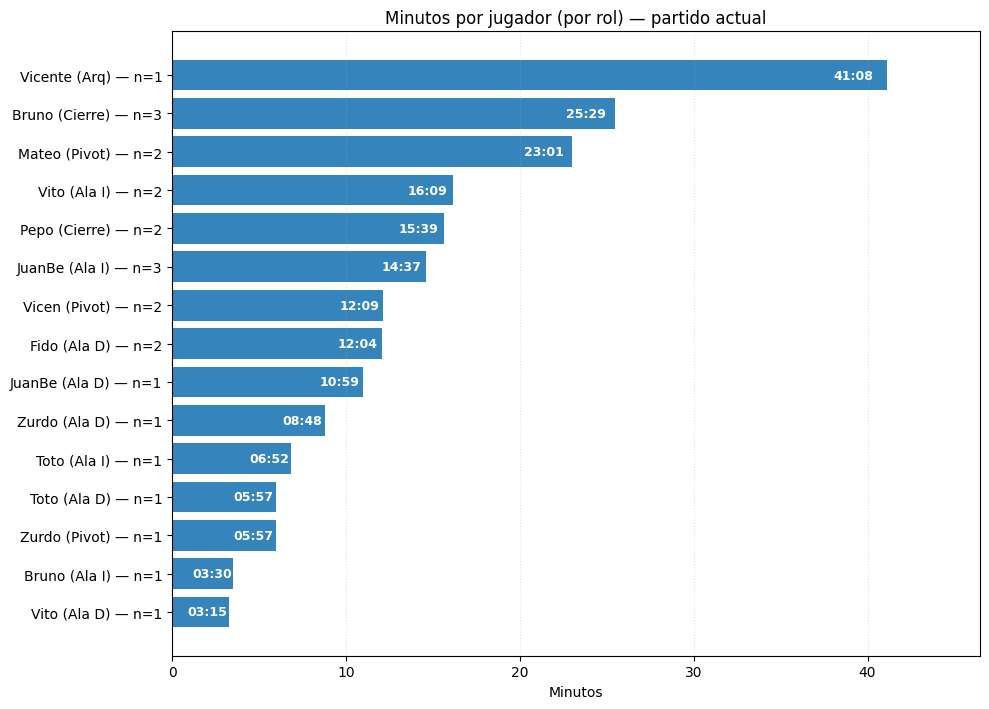

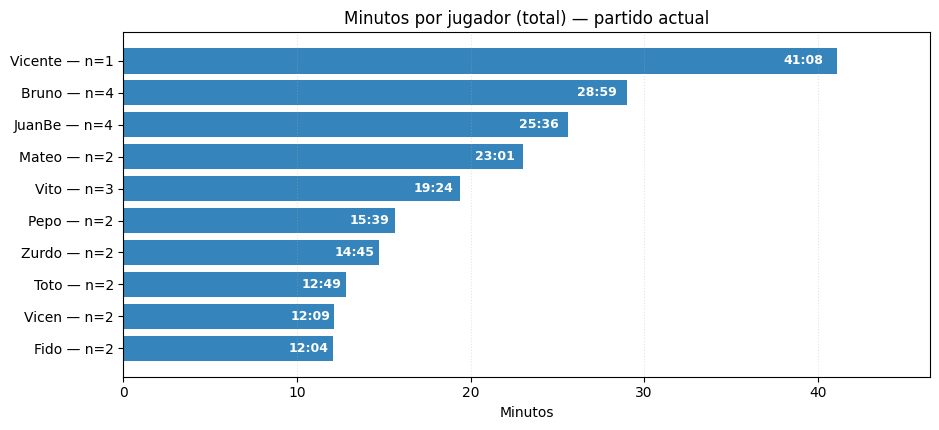

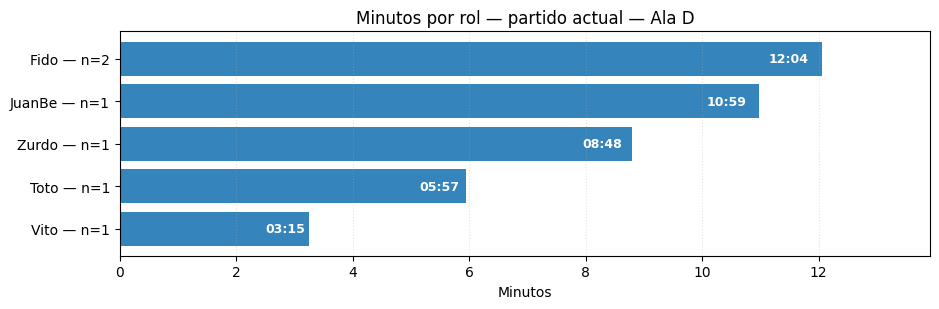

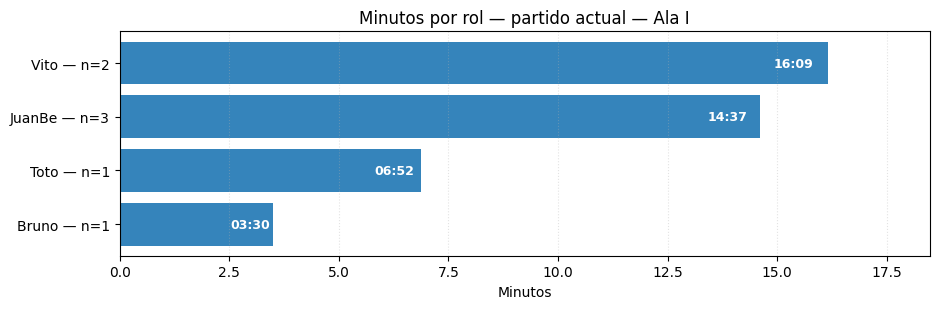

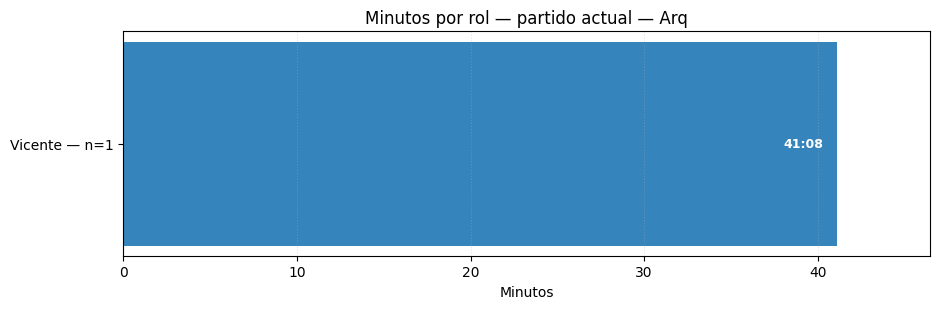

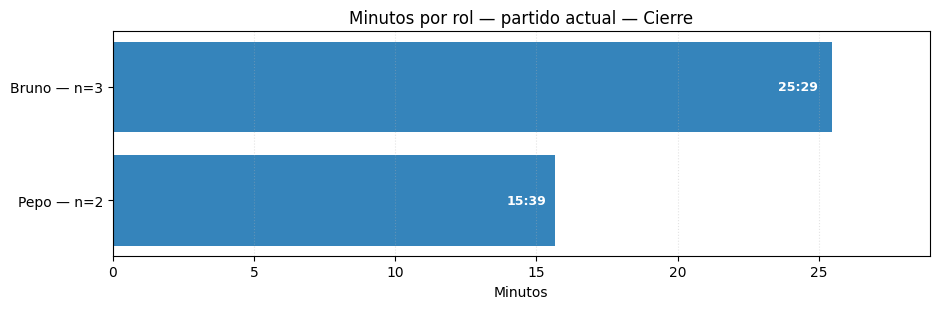

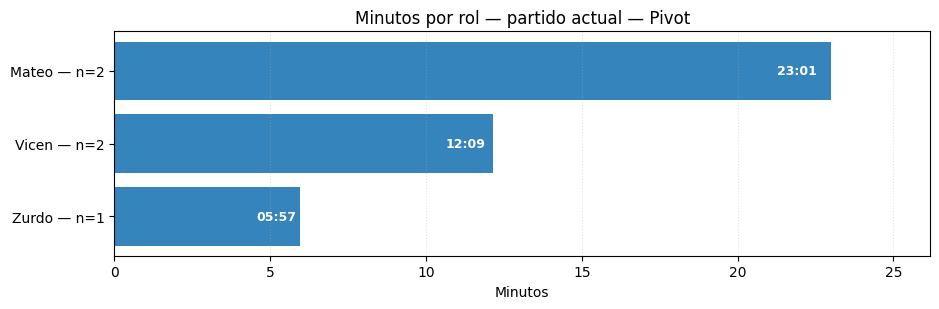

In [17]:
archivo_equipo = _find_equipo_file()
if archivo_equipo is None:
    print("Revisá arriba el listado para confirmar el nombre.")
else:
    print("✅ Usando:", archivo_equipo)
    df_pres = cargar_equipo_presencias(archivo_equipo)
    df_min_por_rol, df_min_por_jugador = minutos_por_presencia(df_pres)

    # Tablas "lindas" (MM:SS y n_tramos)
    cols_rol     = ["nombre","rol","mmss","minutos","n_tramos"]
    cols_jugador = ["nombre","mmss","minutos","n_tramos"]
    print(df_min_por_rol[cols_rol])
    print(df_min_por_jugador[cols_jugador])

    # Gráficos:
    plot_minutos_por_rol(df_min_por_rol)                         # jugador (rol)
    plot_minutos_por_jugador_total(df_min_por_jugador)           # jugador total
    plot_minutos_por_cada_rol(df_min_por_rol)                    # un fig por rol
